<a href="https://colab.research.google.com/github/BDouchet/SDATA/blob/main/Bootstrap_Particle_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Kitagawa model

Kitagawa model is defined as follow :

> $x_t = \frac{x_{t-1}}{2}+25\frac{x_{t-1}}{1+x_{t-1}^2}+8cos(1.2t)+u_t = f(x_{t-1})+ u_t$


> $y_t = \frac{x_t^2}{20}+v_t = h(x_t) + v_t$

with $u_t \sim \mathcal{N}(0,\sigma_u^2)$, $v_t \sim \mathcal{N}(0,\sigma_v^2)$ and  $x_0 \sim \mathcal{N}(0,\sigma_0^2)$.

Initialization fo the parameters :

*  $T=50$, the number of time steps we are considering.
*  $\sigma_u^2=Var(u)=10$
*  $\sigma_v^2=Var(v)=1$
*  $\sigma_0^2=Var(x_0)=10$
*  $N=50$, the number of particles considered

In [257]:
np.random.seed(0)

T=50 # Number time steps
var_u = 10
var_v = 1
var_0 = 10
N=50 # Number of particles

x0=np.random.normal(0,var_0)

In [258]:
def f(x,t):
    return 0.5*x + 25 * x/(1+x**2)+8*math.cos(1.2*t)

def h(x):
    return x**2/20

In [259]:
xts=[x0]
yts=[x0**2/20+np.random.normal(0,var_v)]
for i in range(1,T):
    x_t1=xts[-1]
    x_t=f(x_t1,i)+np.random.normal(0,var_u)
    xts.append(x_t)
    yts.append(h(x_t)+np.random.normal(0,var_v))
xts=np.array(xts)
yts=np.array(yts)
print(xts.shape,yts.shape)

(50,) (50,)


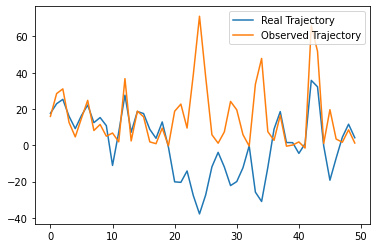

In [260]:
plt.plot(xts,label='Real Trajectory')
plt.plot(yts,label='Observed Trajectory')
plt.legend(loc='upper right')
plt.show()

# Bootstrap Particle filter

## Mathematical Background

The Bootstrap particle filter is a recursive algortithm.

For the **Initialization**, we draw $N$ samples from the prior $p(x_0)$. The weights are initialized as follow : $w_0^{(i)}=\frac{1}{N}$.

The **Recursive** part is divided in four parts : Propagation, Update, Estimation and Resampling. The idea is to estimate $x_t$ thanks to the previous estimations.

*  **Propagation** : draw $N$ times $x_t^{(i)}$ from the prior $p(x_t|x_{t-1}^{(i)}) = \mathcal{N}(f(x_{t-1}^{(i)}),\sigma_u^2)$

* **Update** : Computation of the importance weights : $w_t^{(i)} = p(y_t|x_t^{(i)}) = \alpha*e^{-\frac{[y_t-h(x_t^{(i)})]^2}{2*\sigma_v^2}}$. $\alpha$ a constant which is useless to calculate because we normalize the weights :

  $\widetilde{w}_t^{(i)}=\frac{w_t^{(i)}}{\sum_i^N{w_t^{(i)}}}$  

* **Estimation** : $\hat{x}_t = \sum_i^N{\widetilde{w}_t^{(i)}x_t^{(i)}}$

* **Resampling** : Resample the $x_t^{(i)}$ with the standard mutlinomial resampling method. The idea is to calculate the cumulative distribution of the importance weights and resample thanks to this distribution.

## Implementation

In [261]:
particles_0=np.array([np.random.normal(0,var_0) for _ in range(N)])
weights=np.array([1/N for _ in range(N)])

In [262]:
def resample(particles, weights):
    cumulative_sum = np.cumsum(weights)
    indexes = np.searchsorted(cumulative_sum, np.random.random(N))
    new_particles= [particles[index] for index in indexes]
    #print(indexes)
    #weights.fill(1.0 / N)
    return new_particles

def step(prev_particles,t):
    new_particles=[]
    for i in range(N):
        new_particles.append(np.random.normal(f(prev_particles[i],t),var_u)) # Propagation
        weights[i]= np.exp( - (yts[t] - h(new_particles[i]))**2 / (2*var_v) )+ 1E-308 # Weight Importance
    w_out_norm = np.array([w/np.sum(weights) for w in weights]) # Weight Normalization
    xm = np.sum(np.array(new_particles)*np.array(w_out_norm)) # Estimation
    resampled_particles = resample(new_particles,w_out_norm) # Resampling
    return xm,resampled_particles


In [263]:
particles=[particles_0]
xms=[x0]

for i in range(1,50):
    xm,new_particles=step(particles[-1],i)
    xms.append(xm)
    particles.append(new_particles)


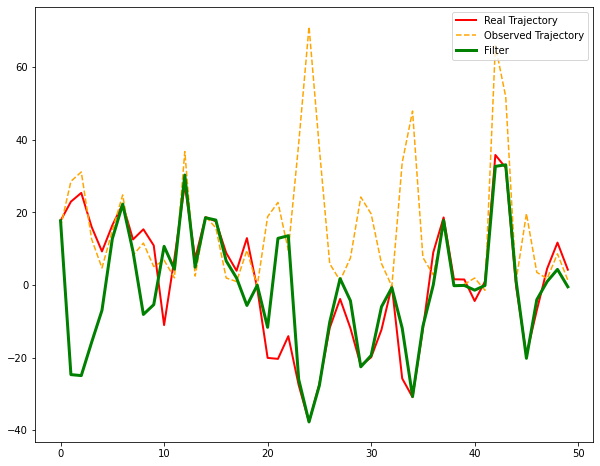

In [264]:
plt.figure(figsize=(10,8))
plt.plot(xts,color='red',linewidth=2,label='Real Trajectory')
plt.plot(yts,linestyle='--',color='orange',label='Observed Trajectory')
plt.plot(xms,color='green',linewidth=3,label='Filter')
plt.legend(loc='upper right')
plt.show()

# Calculation of the MSE with many cases

In [255]:
from sklearn.metrics import mean_squared_error
np.random.seed(0)
mse_filt=[]
mse_obs=[]

for _ in range(100):
    x0=np.random.normal(0,var_0)
    
    xts=[x0]
    yts=[x0**2/20+np.random.normal(0,var_v)]

    for i in range(1,T):
        x_t1=xts[-1]
        x_t=f(x_t1,i)+np.random.normal(0,var_u)
        xts.append(x_t)
        yts.append(h(x_t)+np.random.normal(0,var_v))

    xts=np.array(xts)
    yts=np.array(yts)

    particles_0=np.array([np.random.normal(0,var_0) for _ in range(N)])
    weights=np.array([1/N for _ in range(N)])

    particles=[particles_0]
    xms=[x0]

    for i in range(1,50):
        xm,new_particles=step(particles[-1],i)
        xms.append(xm)
        particles.append(new_particles)
        if math.isnan(xm):
            print(xm,new_particles,weights,(yts[i] - h(new_particles[i]))**2)
    
    
    mse_filt.append(mean_squared_error(xts,xms))
    mse_obs.append(mean_squared_error(xts,yts))


In [256]:
print(np.average(mse_filt))
print(np.average(mse_obs))

218.50215117728524
575.1685993269492
